# Sentiment Analysis using BERT



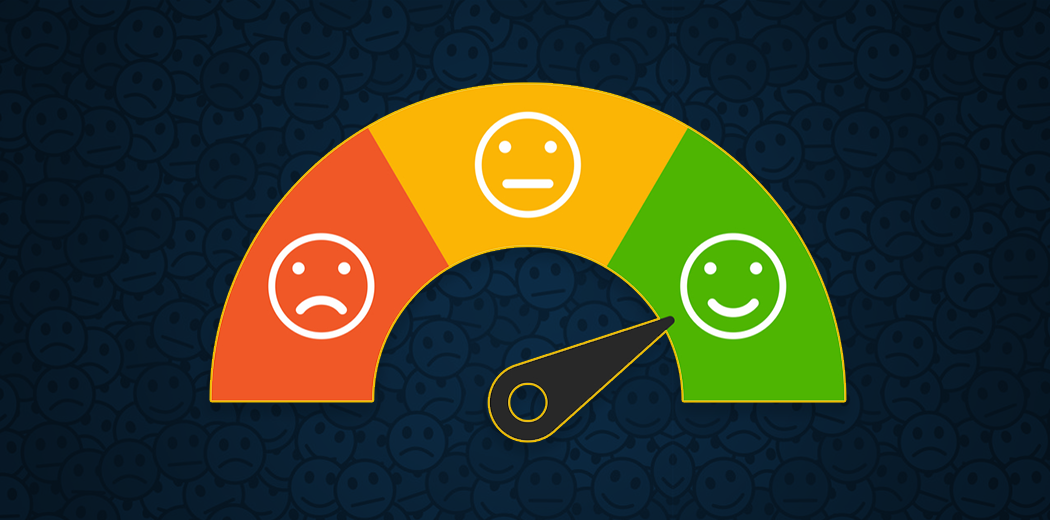

In this tutorial, we harness the power of BERT (Bidirectional Encoder Representations from Transformers), a revolutionary NLP model, for sentiment analysis. BERT's pre-training on extensive text corpora equips it to capture nuanced contextual information within sentences.

### 1. Download and import libraries

In [ ]:
pip install transformers

In [15]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

### 2. Sample data

In [3]:
texts = [
    "I love this product!",
    "This is okay, not great.",
    "I hate this service.",
    "The weather is fantastic today.",
    "I feel indifferent about this movie.",
    "The food was terrible, never going back.",
    "I'm very excited about the upcoming event.",
    "The customer support was superb!",
]

 # Mapping: 'positive' -> 2, 'neutral' -> 1, 'negative' -> 0
labels = [2, 1, 0, 2, 1, 0, 2, 2]

This is a list of sample text data containing various sentences or phrases. Each element in the list represents a piece of text that you want to analyze sentiment for.
For example, "I love this product!" and "The customer support was superb!" are positive sentiments, while "I hate this service." and "The food was terrible, never going back." are negative sentiments.
These text samples are the input data for your sentiment analysis model.

### 3. Preprocessing and setting up BERT

In [4]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We are setting up a BERT-based model for sentiment analysis. First, we load the pre-trained weights and tokenizer specific to 'bert-base-uncased' and then configure the model for a three-class classification task (positive, negative and netural)

In [5]:
tokenized_texts = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

In [16]:
tokenized_texts

{'input_ids': tensor([[  101,  1045,  2293,  2023,  4031,   999,   102,     0,     0,     0,
             0,     0],
        [  101,  2023,  2003,  3100,  1010,  2025,  2307,  1012,   102,     0,
             0,     0],
        [  101,  1045,  5223,  2023,  2326,  1012,   102,     0,     0,     0,
             0,     0],
        [  101,  1996,  4633,  2003, 10392,  2651,  1012,   102,     0,     0,
             0,     0],
        [  101,  1045,  2514, 24436,  2055,  2023,  3185,  1012,   102,     0,
             0,     0],
        [  101,  1996,  2833,  2001,  6659,  1010,  2196,  2183,  2067,  1012,
           102,     0],
        [  101,  1045,  1005,  1049,  2200,  7568,  2055,  1996,  9046,  2724,
          1012,   102],
        [  101,  1996,  8013,  2490,  2001, 21688,   999,   102,     0,     0,
             0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    

tokenized_texts variable contains the tokenized representations of the text samples, ready to be used as input to the BERT-based sentiment analysis model.

In [6]:
labels = torch.tensor(labels)

This conversion allows you to work with the labels in a tensor format, making it compatible with the PyTorch framework and suitable for training and evaluating the model

In [7]:
dataset = TensorDataset(tokenized_texts['input_ids'], tokenized_texts['attention_mask'], labels)
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

We are preparing the dataset for training and creating a DataLoader.

1. *dataset* is an instance of TensorDataset, a PyTorch utility that combines the tokenized input data and labels into a single dataset.

2. *The attention mask* indicates which tokens are actual data and which are padding tokens.

3. *batch_size* specifies how many data samples are processed in each iteration during training

4. *dataloader* is created using DataLoader, a PyTorch utility that wraps your dataset and allows you to efficiently iterate over batches of data.

In [8]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


We are using the AdamW optimizer, a variant of the Adam optimizer that you are familiar with, for updating the model's weights during training with a small learning rate.

The loss function is CrossEntropy, which is often used for multi-class classification.


In [9]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}")


Epoch 1/10, Average Training Loss: 1.1057
Epoch 2/10, Average Training Loss: 0.9725
Epoch 3/10, Average Training Loss: 0.9769
Epoch 4/10, Average Training Loss: 0.8926
Epoch 5/10, Average Training Loss: 0.8607
Epoch 6/10, Average Training Loss: 0.8246
Epoch 7/10, Average Training Loss: 0.7839
Epoch 8/10, Average Training Loss: 0.7991
Epoch 9/10, Average Training Loss: 0.7402
Epoch 10/10, Average Training Loss: 0.7205


We are implementing the training loop for your BERT-based sentiment analysis model using 10 epochs.  Each epoch represents one complete pass through the entire training dataset.

In [10]:
model.eval()
all_predictions = []
all_labels = []

This cell is for evaluation of the model and initializing variables to store predictions and labels.

In [18]:
for batch in dataloader:
    input_ids, attention_mask, labels = batch
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()
    all_predictions.extend(predictions)
    all_labels.extend(labels.tolist())

accuracy = accuracy_score(all_labels, all_predictions)
print(f" Accuracy: {accuracy * 100:.2f}%")

 Accuracy: 87.50%


## Exercise:
**1. Visualize the results :** using the library matplotlib or seaborn

**2. Finetune the results :** Improve upon the BERT model and report your results

**3. Use a dataset:** In this example, we've only used short sentences to demonstrate. Choose a dataset from Kaggle and perform sentiment analysis on it.
  